In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
import verifyml.model_card_toolkit as mctlib
import verifyml.model_tests.utils as utils


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

sns.set_theme(style="whitegrid")

In [36]:
# Load training dataset
df_train = pd.read_csv('/Users/lihao/Downloads/dataset.csv')
X_train_full = df_train.iloc[:,1:].drop('target_variable', axis=1)

y_train_full = df_train['target_variable']
X_train_full.shape

(35899, 15)

In [37]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

In [38]:
# create model instance
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

# fit model
bst.fit(X_train, y_train)

# make predictions
preds = bst.predict(X_test)

### Confusion matrix

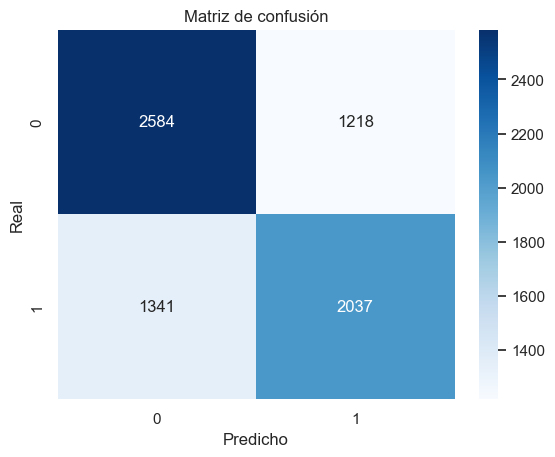

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

In [40]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67      3802
           1       0.63      0.60      0.61      3378

    accuracy                           0.64      7180
   macro avg       0.64      0.64      0.64      7180
weighted avg       0.64      0.64      0.64      7180



In [41]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el modelo base
bst = XGBClassifier(objective='binary:logistic')

# Espacio de búsqueda
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Búsqueda aleatoria (más rápida que GridSearch)
search = RandomizedSearchCV(
    estimator=bst,
    param_distributions=param_grid,
    n_iter=20,  # Número de combinaciones a probar
    scoring='f1',  # Optimizar F1-score
    cv=StratifiedKFold(n_splits=5),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Entrenar
search.fit(X_train, y_train)

# Mejor modelo
best_bst = search.best_estimator_
print("Mejores parámetros:", search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3802
           1       0.82      0.82      0.82      3378

    accuracy                           0.83      7180
   macro avg       0.83      0.83      0.83      7180
weighted avg       0.83      0.83      0.83      7180



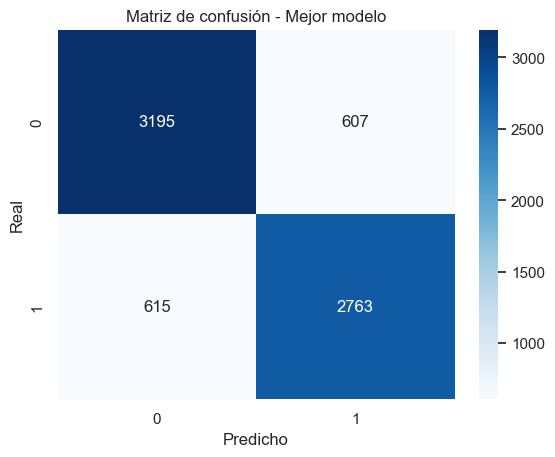

In [42]:
# Predecir con el mejor modelo
preds_best = best_bst.predict(X_test)

# Calcular métricas
print(classification_report(y_test, preds_best))

# Matriz de confusión
cm_best = confusion_matrix(y_test, preds_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión - Mejor modelo')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

Usamos SHAP

In [50]:
import shap

# Crear el explainer
explainer = shap.TreeExplainer(best_bst)

# Calcular los valores SHAP para tus datos de prueba
shap_values = explainer.shap_values(X_test)

expected_value = explainer.expected_value

print("Forma de shap_values:", shap_values.shape)
print("Valor base (expected_value):", expected_value)

Forma de shap_values: (7180, 15)
Valor base (expected_value): -0.119863234


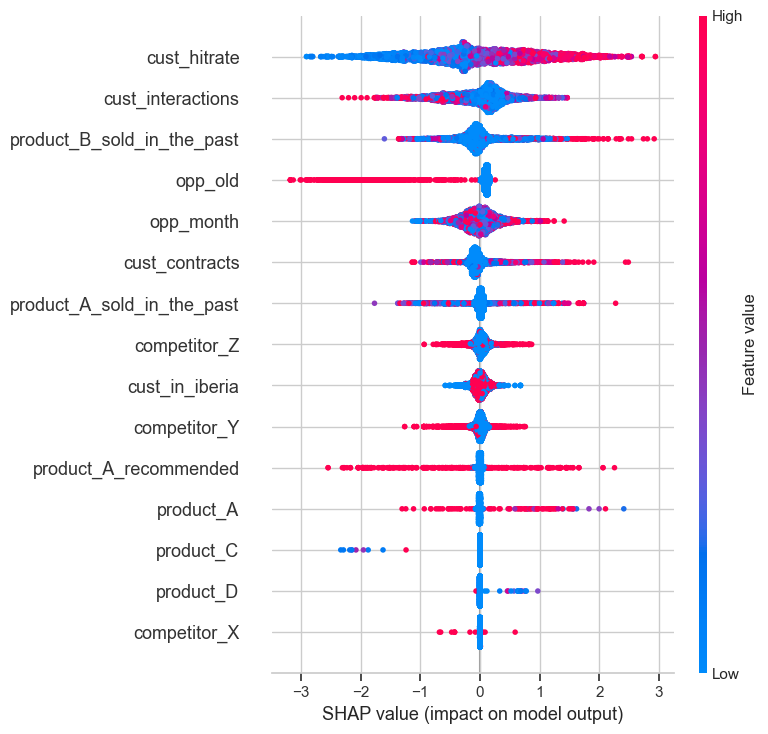

In [44]:
shap.summary_plot(shap_values, X_test, plot_type="dot")

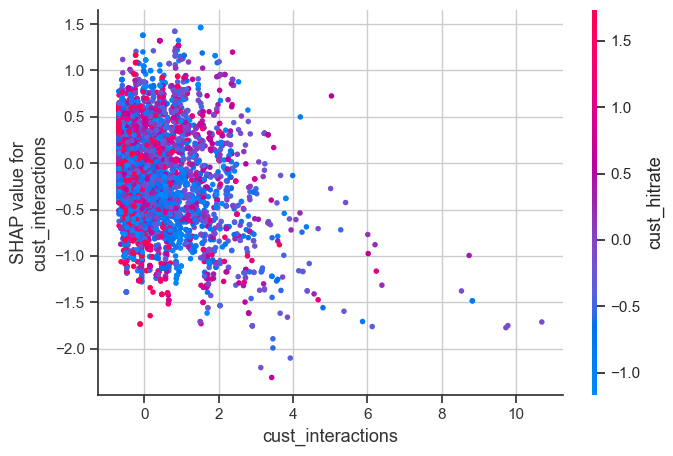

In [51]:
shap.dependence_plot("cust_interactions", shap_values, X_test)

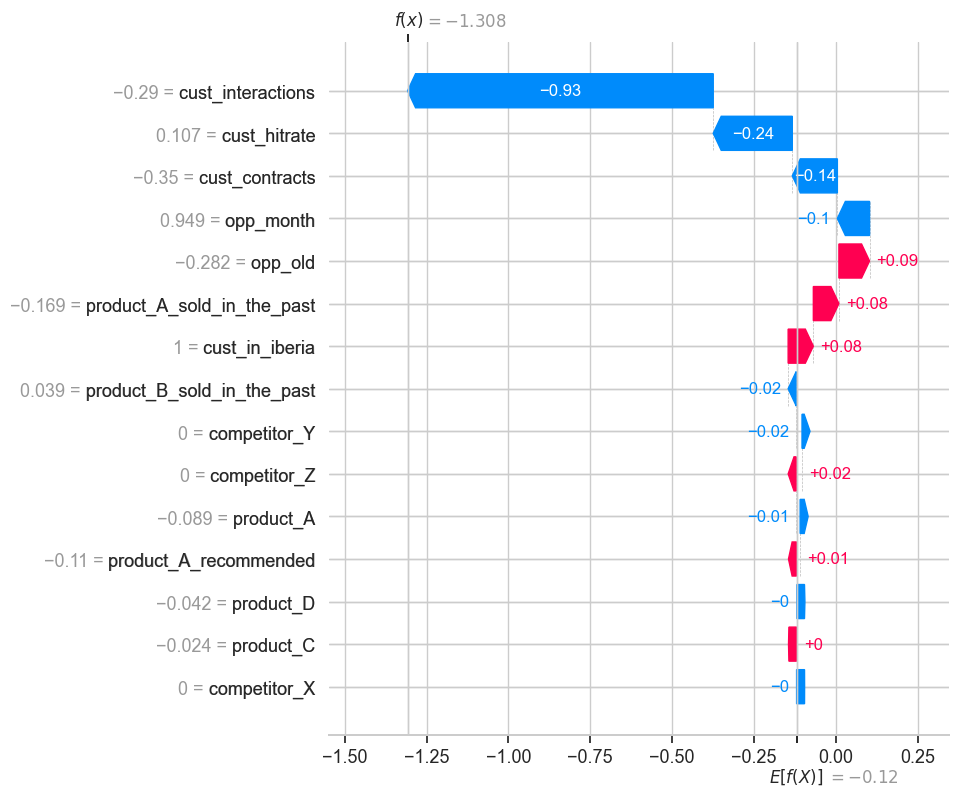

In [54]:
# Waterfall plot (recomendado en SHAP moderno)
# Solo la primera instancia
explanation = explainer(X_test.iloc[:1])  
shap.waterfall_plot(explanation[0], max_display=len(X_test.columns))


Expected Value de la predicción del modelo: -0.12 => 

Calcular gráfico del valor promedio absoluto de SHAP

In [47]:
# Calcular el valor absoluto medio por característica
mean_abs_shap = np.abs(shap_values).mean(axis=0)  # Promedio sobre todas las instancias

# Crear DataFrame para facilitar la visualización
feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"Feature_{i}" for i in range(X_test.shape[1])]
importance_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

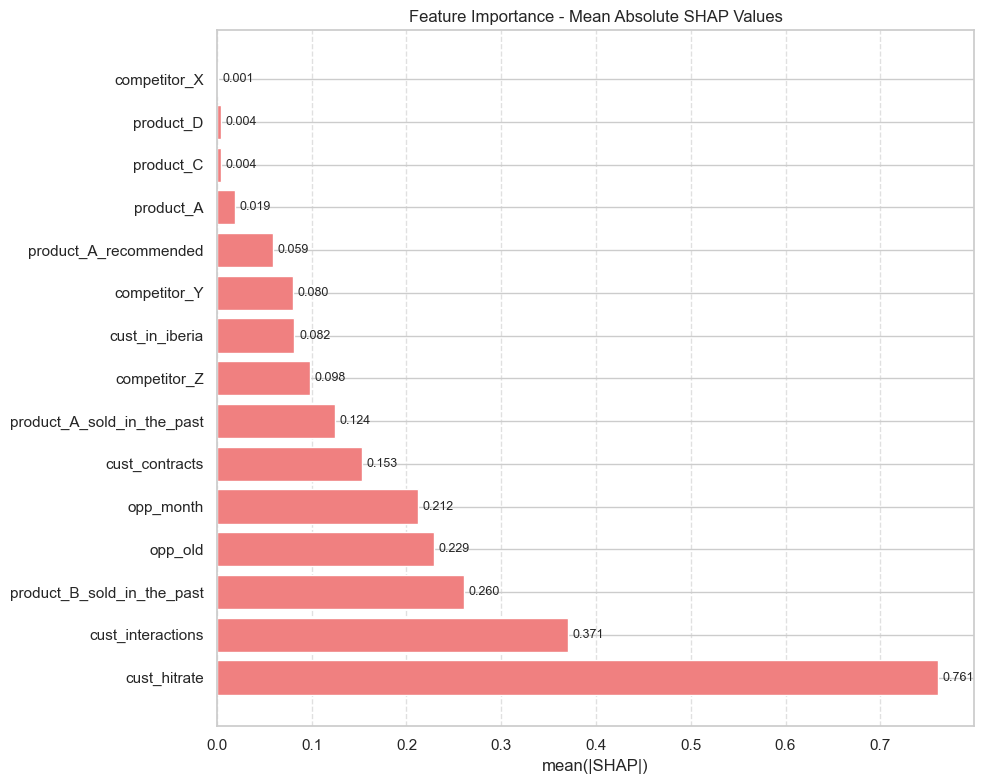

In [49]:
plt.figure(figsize=(10, 8))
bars = plt.barh(importance_df['feature'], importance_df['mean_abs_shap'], color='lightcoral')

# Añadir valores numéricos en las barras
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
             ha='left', va='center', fontsize=9)

plt.xlabel('mean(|SHAP|)')
plt.title('Feature Importance - Mean Absolute SHAP Values')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Ahora probaremos con el ALE

In [ ]:
# %pip install dalex

     ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
     ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
     ---------------------------------------- 1.0/1.0 MB 5.6 MB/s  0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/19.1 MB ? eta -:--:--
   -- ------------------------------------- 1.3/19.1 MB 8.2 MB/s eta 0:00:03
   ------- -------------------------------- 3.4/19.1 MB 9.5 MB/s eta 0:00:02
   --------- ------------------------------ 4.5/19.1 MB 9.7 MB/s eta 0:00:02
   -------------- ------------------------- 7.1/19.1 MB 8.8 MB/s eta 0:00:02
   ------------------ --------------------- 8.9/19.1 MB 9.2 MB/s eta 0:00:0

In [31]:
import dalex as dx

# Definir función de predicción que acepte modelo y datos
def predict_fn(model, X):
    return model.predict_proba(X)[:, 1]

# Crear el explainer
explainer = dx.Explainer(
    model=best_bst,
    data=X_test,
    predict_function=predict_fn  # función que acepta (model, X)
)

# ALE plot
ale_obj = explainer.model_profile(type='accumulated', variables=['cust_interactions'])
ale_obj.plot()

Preparation of a new explainer is initiated

  -> data              : 7180 rows 15 cols
  -> target variable   : Not specified!
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function predict_fn at 0x000002262A7234C0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00035, mean = 0.468, max = 0.998
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> model_info        : package xgboost

A new explainer has been created!


Calculating ceteris paribus:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating accumulated dependency:   0%|          | 0/1 [00:00<?, ?it/s]c:\Users\lihao\OneDrive\桌面\UNI\2n\Q3\IAA\.venv\Lib\site-packages\dalex\model_explanations\_aggregated_profiles\utils.py:85: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  apply(lambda point: (point['_yhat_'] * point['_w_']).sum() / point['_w_'].sum() \
c:\Users\lihao\OneDrive\桌面\UNI\2n\Q3\IAA\.venv\Lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after gr

In [32]:
ale_obj = explainer.model_profile(
    type='accumulated',
    variables=['cust_interactions', 'opp_old', 'product_A_sold_in_the_past']
)
ale_obj.plot()

Calculating accumulated dependency:   0%|          | 0/3 [00:00<?, ?it/s]c:\Users\lihao\OneDrive\桌面\UNI\2n\Q3\IAA\.venv\Lib\site-packages\dalex\model_explanations\_aggregated_profiles\utils.py:85: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\Users\lihao\OneDrive\桌面\UNI\2n\Q3\IAA\.venv\Lib\site-packages\dalex\model_explanations\_aggregated_profiles\utils.py:85: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

c:\User